In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/alternate/sample_mapping.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
import lifelines
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings('ignore')

In [3]:
hnsc_clinical = pd.read_csv('/cellar/users/ramarty/Data/kir/TCGA/hnsc_clinical/viral_status.csv', index_col=0)

In [4]:
df = pd.read_csv('/cellar/users/ramarty/Data/kir/TCGA/data_frames/all_the_good_stuff.excluded_close_boundaries.csv', index_col=0)
print len(df)

3501


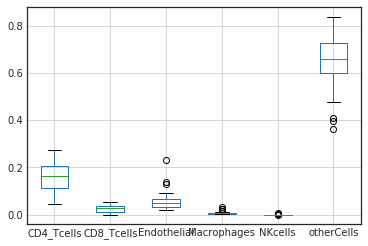

In [5]:
df[df.tissue == 'CESC'][['CD4_Tcells', u'CD8_Tcells', u'Endothelial', u'Macrophages',
       u'NKcells', u'otherCells']].boxplot()

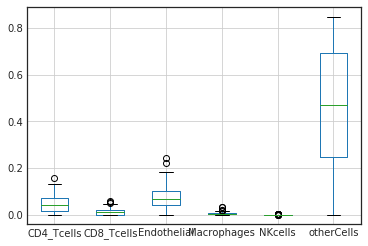

In [6]:
df[df.tissue == 'UCS'][['CD4_Tcells', u'CD8_Tcells', u'Endothelial', u'Macrophages',
       u'NKcells', u'otherCells']].boxplot()

In [7]:
def combine_days(x):
    to_death = x[0]
    follow_up = x[1]
    try:
        return float(to_death)
    except:
        return float(follow_up)
def observed_death(x):
    if x == 'Alive':
        return False
    else:
        return True

In [8]:
df['days'] = df[['days_to_death', 'days_to_last_followup']].apply(combine_days, axis=1)
df['observed_event'] = df['vital_status'].apply(observed_death)

In [9]:
patient_affinities = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/patient_affinities.cancer.PHBR.csv',
                                index_col=0)
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/patient_mutations.cancer.PHBR.csv',
                                index_col=0)

In [14]:
t = (df.tissue == 'CESC')|(df.tissue == 'UCS')

In [15]:
many_patients = list(df[t][inhibitory].index)
few_patients = (list(df[t][~inhibitory].index))
other_patients = [x for x in df.index if x not in many_patients+few_patients and x in patient_affinities.index]

In [16]:
uc_observed, other_observed = [], []
for mutation in patient_affinities.columns:
    uc_observed.extend(list(patient_affinities.loc[few_patients+many_patients][patient_mutations[mutation].astype(bool)][mutation]))
    other_observed.extend(list(patient_affinities.loc[other_patients][patient_mutations[mutation].astype(bool)][mutation]))
plotting_df = pd.DataFrame({'PHBR': uc_observed + other_observed,
                           'Tissue': ['CESC or UCS' for x in uc_observed] + ['Other' for x in other_observed]})

In [17]:
uc_observed, other_observed = [], []
for mutation in patient_affinities.columns:
    uc_observed.extend(list(patient_affinities.loc[few_patients][patient_mutations[mutation].astype(bool)][mutation]))
    other_observed.extend(list(patient_affinities.loc[many_patients][patient_mutations[mutation].astype(bool)][mutation]))
plotting_df_specifc = pd.DataFrame({'PHBR': uc_observed + other_observed,
                           'Tissue': ['Few' for x in uc_observed] + ['Many' for x in other_observed]})

### Tissue dependent

Activating/inhibitory

In [18]:
len(df[(df.tissue == 'CESC')|(df.tissue == 'UCS')])

86

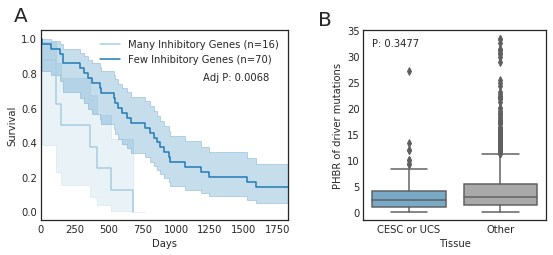

In [21]:
fig = plt.figure(figsize=(16, 3.5))
num_rows, num_columns = 1, 14

ax0 = plt.subplot2grid((num_rows, num_columns), (0, 0), rowspan=1, colspan=4)
kmf = KaplanMeierFitter()
t = (df.tissue == 'CESC')|(df.tissue == 'UCS')
inhibitory = df[t].inhibitory > df[t].inhibitory.quantile(0.5)

T = df[t].days
C = df[t].observed_event

results = logrank_test(T[inhibitory], T[~inhibitory], C[inhibitory], 
                       C[~inhibitory], alpha=.99 )
kmf.fit(T[inhibitory], event_observed=C[inhibitory], 
        label="Many Inhibitory Genes (n={0})".format(len(T[inhibitory])))
kmf.plot(ax=ax0, ci_force_lines=False, color=sns.color_palette("Paired")[0])
kmf.fit(T[~inhibitory], event_observed=C[~inhibitory], 
        label="Few Inhibitory Genes (n={0})".format(len(T[~inhibitory])))
kmf.plot(ax=ax0, ci_force_lines=False, color=sns.color_palette("Paired")[1])
plt.xlim(0, 1825)
plt.xlabel('Days')
plt.ylabel('Survival')
plt.text(1200, .76, 'Adj P: {0}'.format(round(results.p_value, 4)*17))
plt.text(-200, 1.1, 'A', size= 20)

ax1 = plt.subplot2grid((num_rows, num_columns), (0, 5), rowspan=1, colspan=3)
sns.boxplot(x='Tissue', y='PHBR', data=plotting_df, 
            palette=[sns.color_palette("Blues",5)[2], 'darkgrey'])
plt.ylabel('PHBR of driver mutations')
plt.text(-0.4, 32, 'P: {0}'.format(round(sp.mannwhitneyu(uc_observed, other_observed)[1], 4)))
plt.text(-1, 36, 'B', size= 20)

#ax2 = plt.subplot2grid((num_rows, num_columns), (0, 9), rowspan=1, colspan=3)
#sns.boxplot(x='Inhibitory Genes', y='CD8 Tcells', data=tmp, 
#            palette=sns.color_palette("Paired"))
#plt.text(-.4, 0.055, 'P: {0}'.format(round(sp.mannwhitneyu(tmp[tmp['Inhibitory Genes'] == 'Many']['CD8 Tcells'],
#               tmp[tmp['Inhibitory Genes'] == 'Few']['CD8 Tcells'])[1], 4)))
#plt.text(-1, 0.062, 'C', size= 20)

# add p-values, adjust placement of p-values

plt.savefig('/cellar/users/ramarty/Data/kir/manuscript_figures/figure_7.pdf', bbox_inches='tight')

In [42]:
round(sp.mannwhitneyu(tmp[tmp['Inhibitory Genes'] == 'Many']['CD8 Tcells'],
               tmp[tmp['Inhibitory Genes'] == 'Few']['CD8 Tcells'])[1], 4)

0.0111

0.00035518930174415316


Text(1250,0.8,'P-value: 0.00036')

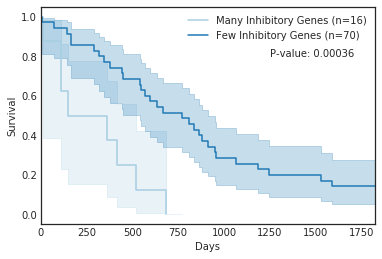

In [43]:
kmf = KaplanMeierFitter()
t = (df.tissue == 'CESC')|(df.tissue == 'UCS')
inhibitory = df[t].inhibitory > df[t].inhibitory.quantile(0.5)

T = df[t].days
C = df[t].observed_event

results = logrank_test(T[inhibitory], T[~inhibitory], C[inhibitory], 
                       C[~inhibitory], alpha=.99 )
if results.p_value < 0.05:
    print results.p_value
    ax = plt.subplot(111)
    kmf.fit(T[inhibitory], event_observed=C[inhibitory], 
            label="Many Inhibitory Genes (n={0})".format(len(T[inhibitory])))
    kmf.plot(ax=ax, ci_force_lines=False, color=sns.color_palette("Paired")[0])
    kmf.fit(T[~inhibitory], event_observed=C[~inhibitory], 
            label="Few Inhibitory Genes (n={0})".format(len(T[~inhibitory])))
    kmf.plot(ax=ax, ci_force_lines=False, color=sns.color_palette("Paired")[1])
    plt.xlim(0, 1825)
    plt.xlabel('Days')
    plt.ylabel('Survival')
plt.text(1250, .8, 'P-value: {0}'.format(round(results.p_value, 5)))
    

Text(0,0.5,'PHBR-I of driver mutations')

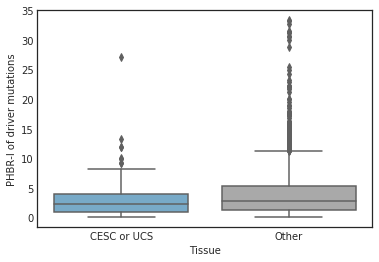

In [60]:
sns.boxplot(x='Tissue', y='PHBR', data=plotting_df, 
            palette=[sns.color_palette("Blues",5)[2], 'darkgrey'])
plt.ylabel('PHBR-I of driver mutations')

Text(0,0.5,'PHBR-I of driver mutations')

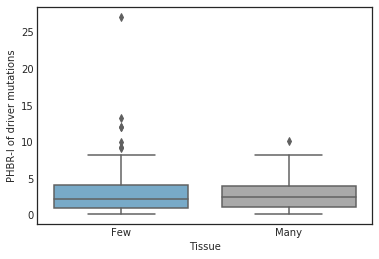

In [64]:
sns.boxplot(x='Tissue', y='PHBR', data=plotting_df_specifc, 
            palette=[sns.color_palette("Blues",5)[2], 'darkgrey'])
plt.ylabel('PHBR-I of driver mutations')

In [65]:
sp.mannwhitneyu(plotting_df_specifc[plotting_df_specifc.Tissue == 'Few'].PHBR,
               plotting_df_specifc[plotting_df_specifc.Tissue == 'Many'].PHBR)

MannwhitneyuResult(statistic=1198.0, pvalue=0.34771175281376276)

In [45]:
df.columns

Index([u'KIR3DL3', u'KIR3DP1', u'KIR2DL4', u'KIR3DL2', u'KIR2DP1', u'KIR2DL1',
       u'KIR2DS4', u'KIR2DS3', u'KIR2DS2', u'KIR2DS5', u'KIR3DS1', u'KIR2DS1',
       u'KIR2DL2', u'KIR3DL1', u'KIR2DL3', u'KIR2DL5A', u'age_at_diagnosis',
       u'days_to_death', u'days_to_last_followup', u'ethnicity', u'gender',
       u'race', u'tissue', u'vital_status', u'B cells naive',
       u'B cells memory', u'Plasma cells', u'T cells CD8',
       u'T cells CD4 naive', u'T cells CD4 memory resting',
       u'T cells CD4 memory activated', u'T cells follicular helper',
       u'T cells regulatory (Tregs)', u'T cells gamma delta',
       u'NK cells resting', u'NK cells activated', u'Monocytes',
       u'Macrophages M0', u'Macrophages M1', u'Macrophages M2',
       u'Dendritic cells resting', u'Dendritic cells activated',
       u'Mast cells resting', u'Mast cells activated', u'Eosinophils',
       u'Neutrophils', u'P-value', u'Pearson Correlation', u'RMSE', u'Bcells',
       u'CAFs', u'CD4_Tcells', u

In [63]:
tmp = pd.DataFrame({'CD8 Tcells': list(df[t][inhibitory]['CD8_Tcells']) + list(df[t][~inhibitory]['CD8_Tcells']),
                    'NKcells': list(df[t][inhibitory]['NKcells']) + list(df[t][~inhibitory]['NKcells']),
              'Inhibitory Genes': ['Many' for x in df[t][inhibitory].days] + ['Few' for x in df[t][~inhibitory].days]})

In [47]:
tmp

,CD8 Tcells,Inhibitory Genes,NKcells
0,2.987146e-06,Many,4.384432e-09
1,3.951459e-02,Many,1.245049e-09
2,4.954911e-03,Many,1.421358e-08
3,6.662363e-06,Many,1.078845e-08
4,3.421975e-02,Many,2.025058e-10
5,1.886285e-02,Many,2.309172e-03
6,2.176839e-06,Many,9.481984e-05
7,7.033154e-03,Many,1.323544e-08
8,1.434282e-02,Many,2.710258e-09
9,6.489790e-05,Many,3.834009e-07


In [48]:
sp.mannwhitneyu(tmp[tmp['Inhibitory Genes'] == 'Many']['CD8 Tcells'],
               tmp[tmp['Inhibitory Genes'] == 'Few']['CD8 Tcells'])

MannwhitneyuResult(statistic=341.0, pvalue=0.007658705205317615)

In [49]:
sp.mannwhitneyu(tmp[tmp['Inhibitory Genes'] == 'Many']['NKcells'],
               tmp[tmp['Inhibitory Genes'] == 'Few']['NKcells'])

MannwhitneyuResult(statistic=481.0, pvalue=0.19183683939774737)

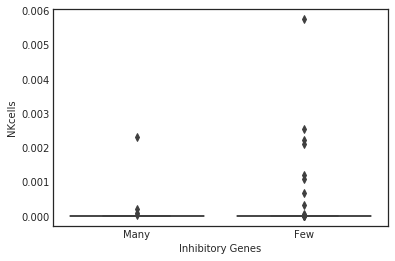

In [50]:
sns.boxplot(x='Inhibitory Genes', y='NKcells', data=tmp, 
            palette=sns.color_palette("Paired"))

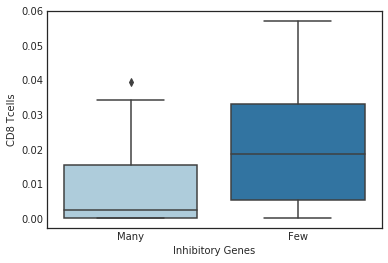

In [51]:
sns.boxplot(x='Inhibitory Genes', y='CD8 Tcells', data=tmp, 
            palette=sns.color_palette("Paired"))

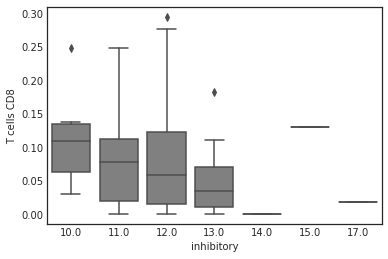

In [52]:
sns.boxplot(x='inhibitory', y='T cells CD8', data=df[t], color='grey')

In [53]:
df[t].inhibitory.quantile(0.5)

12.0

GBM 131 0.7540308824937165
OV 134 0.6763901820311855
LUAD 368 0.2898865173597057
PRAD 287 1.0
LUSC 233 0.8348564995909796
PAAD 104 0.6859805279063332
KIRC 128 0.8231200441276597
KIRP 76 0.465333875992065
STAD 234 0.09389626465753138
HNSC 408 0.7174308327552857
SKCM 68 0.7485115296239209
CESC 37 0.00018281063298183483


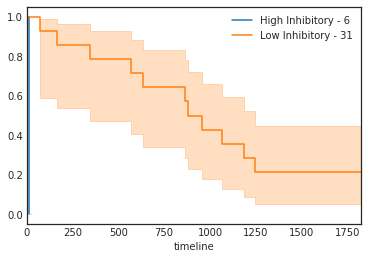

THCA 398 0.10721983583820031
BLCA 187 0.15752325410627652
LGG 453 0.19568143905490035
UCS 49 0.0113730507826893


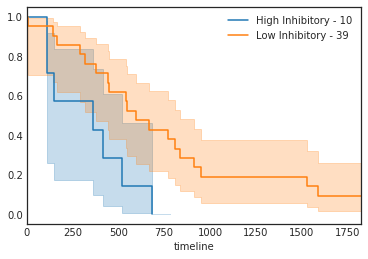

PCPG 148 1.0
UVM 58 0.09479931709401028
18


<Figure size 432x288 with 0 Axes>

In [54]:
kmf = KaplanMeierFitter()

total = 0
for tissue in df.tissue.unique():
    t = df.tissue == tissue
    inhibitory = df[t].inhibitory > df[t].inhibitory.quantile(0.5)
    
    T = df[t].days
    C = df[t].observed_event

    results = logrank_test(T[inhibitory], T[~inhibitory], C[inhibitory], C[~inhibitory], alpha=.99 )
    print tissue, len(df[t]), results.p_value
    if results.p_value < 0.05:
        ax = plt.subplot(111)
        kmf.fit(T[inhibitory], event_observed=C[inhibitory], 
                label="High Inhibitory - {0}".format(len(T[inhibitory])))
        kmf.plot(ax=ax, ci_force_lines=False)
        kmf.fit(T[~inhibitory], event_observed=C[~inhibitory], 
                label="Low Inhibitory - {0}".format(len(T[~inhibitory])))
        kmf.plot(ax=ax, ci_force_lines=False)
        plt.xlim(0, 1825)
        plt.show()
        plt.clf()
    total += 1
print total

In [19]:
kmf = KaplanMeierFitter()
total = 0
for tissue in df.tissue.unique():
    t = df.tissue == tissue
    inhibitory_low = df[t].inhibitory < df[t].inhibitory.quantile(0.25)
    inhibitory_high = df[t].inhibitory > df[t].inhibitory.quantile(0.75)
    
    T = df[t].days
    C = df[t].observed_event

    if sum(C[inhibitory_low]) > 5 and sum(C[inhibitory_high]) > 5:
        print tissue
        results = logrank_test(T[inhibitory_low], T[inhibitory_high], C[inhibitory_low], C[inhibitory_high], alpha=.99 )
        if results.p_value * len(df.tissue.unique()) < 0.05: 
            print tissue, results.p_value* len(df.tissue.unique()), len(T[inhibitory_low]), len(T[inhibitory_high])
            ax = plt.subplot(111)
            kmf.fit(T[inhibitory_high], event_observed=C[inhibitory_high], label="High inhibition")
            kmf.plot(ax=ax, ci_force_lines=False)
            kmf.fit(T[inhibitory_low], event_observed=C[inhibitory_low], label="Low inhibition")
            kmf.plot(ax=ax, ci_force_lines=False)
            plt.xlim(0, 1825)
            print T[inhibitory_low], C[inhibitory_low]


GBM
OV
LUAD
HNSC


In [15]:
kmf = KaplanMeierFitter()

for tissue in df.tissue.unique():
    t = df.tissue == tissue
    inhibitory = df[t].activating > df[t].activating.quantile(0.5)
    
    T = df[t].days
    C = df[t].observed_event

    results = logrank_test(T[inhibitory], T[~inhibitory], C[inhibitory], C[~inhibitory], alpha=.99 )
    print tissue, results.p_value

GBM 0.38486095771812234
OV 0.005941883138883858
LUAD 0.877596818404348
PRAD 1.0
LUSC 0.9286968291130953
PAAD 0.38522010272902285
KIRC 0.030170289430987495
KIRP 0.7157638753802611
STAD 0.5292360419020861
HNSC 0.44191307526833423
SKCM 0.9565731413175254
CESC 0.0932234892441043
THCA 1.0
BLCA 0.0389006848956397
LGG 0.5066649073226407
UCS 0.45529727526892994
PCPG 0.4407019065600808
UVM 0.008526796291467565


In [16]:
kmf = KaplanMeierFitter()

for tissue in df.tissue.unique():
    t = df.tissue == tissue
    inhibitory_low = df[t].activating < df[t].activating.quantile(0.4)
    inhibitory_high = df[t].activating > df[t].activating.quantile(0.6)
    
    T = df[t].days
    C = df[t].observed_event

    results = logrank_test(T[inhibitory_low], T[inhibitory_high], C[inhibitory_low], C[inhibitory_high], alpha=.99 )
    print tissue, results.p_value

GBM 0.12302359041814385
OV 0.05191896167071212
LUAD 0.9582353918584036
PRAD 1.0
LUSC 0.7943324685326932
PAAD 0.8132387807059116
KIRC 0.23176867528236955
KIRP nan
STAD 0.42348519463733114
HNSC 0.8025119601232771
SKCM 0.45470723730273654
CESC nan
THCA 1.0
BLCA 0.05023834665918656
LGG 0.7962130377265731
UCS 0.07707817433421696
PCPG 1.0
UVM 0.022281849739319178


Gene specific

In [21]:
genes = ['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2', 'KIR2DS2', 'KIR2DS3', 'KIR2DP1', 
         'KIR2DL1', 'KIR3DS1', 'KIR2DS5', 'KIR2DS4']

In [23]:
for gene in genes:
    print gene
    for tissue in df.tissue.unique():
        try:
            t = df.tissue == tissue
            inhibitory = df[t][gene] > df[t][gene].quantile(0.5)

            T = df[t].days
            C = df[t].observed_event

            results = logrank_test(T[inhibitory], T[~inhibitory], C[inhibitory], C[~inhibitory], alpha=.99 )
            if results.p_value < 0.05:
                print tissue, gene, results.p_value
        except:
            None
    print ' '

KIR3DL3
KIRC KIR3DL3 1.2131545083660726e-07
HNSC KIR3DL3 0.025685135714815163
UCS KIR3DL3 0.02606139951340767
 
KIR3DP1
 
KIR2DL4
STAD KIR2DL4 1.321632235035784e-52
 
KIR3DL2
OV KIR3DL2 0.014436953825102005
 
KIR2DS2
GBM KIR2DS2 0.0356146721210753
BLCA KIR2DS2 0.023776657022722466
 
KIR2DS3
OV KIR2DS3 0.03845336291738253
SKCM KIR2DS3 0.004677734981047276
 
KIR2DP1
LUAD KIR2DP1 0.01436922558559619
LGG KIR2DP1 0.00011738309060367742
 
KIR2DL1
LUAD KIR2DL1 0.000285067762251422
UCS KIR2DL1 0.00660746688745189
 
KIR3DS1
OV KIR3DS1 0.006069140851461785
 
KIR2DS5
 
KIR2DS4
THCA KIR2DS4 0.004677734981047276
 


### MHC/KIR combinations

In [24]:
hla_a = [x.split(',')[1:3] for x in open('/cellar/users/ramarty/Data/kir/biological/combinations.hla_a.csv').readlines()[1:]]
hla_b = [x.split(',')[1:3] for x in open('/cellar/users/ramarty/Data/kir/biological/combinations.hla_b.csv').readlines()[1:]]
hla_c = [x.split(',')[1:3] for x in open('/cellar/users/ramarty/Data/kir/biological/combinations.hla_c.csv').readlines()[1:]]

In [25]:
hla_a_single = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/biological/singles.A.txt').readlines()]
hla_b_single = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/biological/singles.B.txt').readlines()]
hla_c_single = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/biological/singles.C.txt').readlines()]

In [26]:
hla_a_single_fd = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/biological/singles.A.four_digit.txt').readlines()]
hla_b_single_fd = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/biological/singles.B.four_digit.txt').readlines()]
hla_c_single_fd = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/biological/singles.C.four_digit.txt').readlines()]

### HLA Pairs

A

In [27]:
kmf = KaplanMeierFitter()
predicted_total = 13 # update
total = 0
for hla1, hla2 in hla_a:
    for tissue in df.tissue.unique():
        t = df.tissue == tissue            
        h = (df.A1 == hla1)&(df.A2 == hla2)
        #k = df[gene] > 1

        T = df[t].days
        C = df[t].observed_event

        if sum(C[h]) > 4 and sum(C[~(h)]) > 4:
            total += 1
            results = logrank_test(T[h], T[~h], C[h], C[~h], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[h], event_observed=C[h], label="{0},{1}".format(hla1, hla2))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~h], event_observed=C[~h], label="Other")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.xlim(0, 1825)
                plt.title('{0} - {1}'.format(tissue, results.p_value * predicted_total))
                plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla.{0}.{1}.{2}.pdf'.format(tissue, hla1, hla2))
                plt.show()
                plt.clf()
                
print total

23


In [28]:
predicted_total = 75 # update
total = 0
for gene in genes:
    for hla1, hla2 in hla_a:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.A1 == hla1)&(df.A2 == hla2)
            k = df[gene] > 1
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~(k&h)]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~(k&h)], event_observed=C[~(k&h)], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

118


In [29]:
predicted_total = 6 # update
total = 0
for gene in genes:
    for hla1, hla2 in hla_a:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.A1 == hla1)&(df.A2 == hla2)
            k = df[gene] > 0
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~k&h]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~k&h], event_observed=C[~k&h], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

9


B

In [30]:
predicted_total = 3 # update
total = 0
for hla1, hla2 in hla_b:
    for tissue in df.tissue.unique():
        t = df.tissue == tissue            
        h = (df.B1 == hla1)&(df.B2 == hla2)
        #k = df[gene] > 1

        T = df[t].days
        C = df[t].observed_event

        if sum(C[h]) > 5 and sum(C[~h]) > 5:
            total += 1
            try:
                results = logrank_test(T[h], T[~h], C[h], C[~h], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print sum(C[h]), sum(C[~h])
                    print hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[h], event_observed=C[h], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~h], event_observed=C[~h], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.title('{0} - {1}'.format(tissue, results.p_value * predicted_total))
                    plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla.{0}.{1}.{2}.pdf'.format(tissue, hla1, hla2))
                    plt.show()
                    plt.clf()
            except:
                total -= 1
                
print total

2


In [31]:
predicted_total = 17 # update
total = 0
for gene in genes:
    for hla1, hla2 in hla_b:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.B1 == hla1)&(df.B2 == hla2)
            k = df[gene] > 1
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~(k&h)]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~(k&h)], event_observed=C[~(k&h)], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

17


In [32]:
predicted_total = 4 # update
total = 0
for gene in genes:
    for hla1, hla2 in hla_b:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.B1 == hla1)&(df.B2 == hla2)
            k = df[gene] > 1
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~k&h]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~k&h], event_observed=C[~k&h], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

0


C

In [33]:
predicted_total = 17 # update
total = 0
for hla1, hla2 in hla_c:
    for tissue in df.tissue.unique():
        t = df.tissue == tissue            
        h = (df.C1 == hla1)&(df.C2 == hla2)
        k = df[gene] > 1

        T = df[t].days
        C = df[t].observed_event

        if sum(C[h]) > 4 and sum(C[~h]) > 4:
            total += 1
            results = logrank_test(T[h], T[~h], C[h], C[~h], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[h], event_observed=C[h], label="{0},{1}".format(hla1, hla2))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~h], event_observed=C[~h], label="Other")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.xlim(0, 1825)
                plt.show()
                plt.clf()
                
print total

29


In [34]:
predicted_total = 60 # update
total = 0
for gene in genes:
    for hla1, hla2 in hla_c:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.C1 == hla1)&(df.C2 == hla2)
            k = df[gene] > 0
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 5 and sum(C[~(k&h)]) > 5:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~(k&h)], event_observed=C[~(k&h)], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.title('{0} - {1}'.format(tissue, results.p_value * predicted_total))
                    plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla_kir.{0}.{1}.{2}.{3}.pdf'.format(tissue, hla1, hla2, gene))
                    plt.show()
                    plt.clf()
                
print total

125


In [35]:
predicted_total = 5 # update
total = 0
for gene in genes:
    for hla1, hla2 in hla_c:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue
            df_t = df[t]
            h = (df_t.C1 == hla1)&(df_t.C2 == hla2)
            k = df_t[gene] > 1
            
            T = df_t.days
            C = df_t.observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~k&h]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~k&h], C[k&h], C[~k&h], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="2+ copy of {0}".format(gene))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~k&h], event_observed=C[~k&h], label="<2 copy of {0}".format(gene))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.title('{0},{1},{2}  - {3}'.format(tissue, hla1, hla2, results.p_value * predicted_total))
                    plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla_kir.{0}.{1}.{2}.{3}.pdf'.format(tissue, hla1, hla2, gene))
                    plt.show()
                    plt.clf()
                
print total

1


###Single HLAs

####HLA alone

A

In [31]:
kmf = KaplanMeierFitter()
predicted_total = 37 # update
total = 0
for hla in hla_a_single:
    for tissue in df.tissue.unique():
        t = df.tissue == tissue            
        h = (df.A1 == hla)|(df.A2 == hla)
        #k = df[gene] > 1

        T = df[t].days
        C = df[t].observed_event

        if sum(C[h]) > 10 and sum(C[~(h)]) > 10:
            total += 1
            results = logrank_test(T[h], T[~h], C[h], C[~h], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print hla, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[h], event_observed=C[h], label="{0}".format(hla))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~h], event_observed=C[~h], label="Other")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.xlim(0, 1825)
                plt.title('{0} - {1}'.format(tissue, results.p_value * predicted_total))
                plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla.{0}.{1}.pdf'.format(tissue, hla))
                plt.show()
                plt.clf()
                
print total

33


B

In [32]:
kmf = KaplanMeierFitter()
predicted_total = 37 # update
total = 0
for hla in hla_b_single:
    for tissue in df.tissue.unique():
        t = df.tissue == tissue            
        h = (df.B1 == hla)|(df.B2 == hla)
        #k = df[gene] > 1

        T = df[t].days
        C = df[t].observed_event

        if sum(C[h]) > 10 and sum(C[~(h)]) > 10:
            total += 1
            results = logrank_test(T[h], T[~h], C[h], C[~h], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print hla, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[h], event_observed=C[h], label="{0}".format(hla))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~h], event_observed=C[~h], label="Other")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.xlim(0, 1825)
                plt.title('{0} - {1}'.format(tissue, results.p_value * predicted_total))
                plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla.{0}.{1}.pdf'.format(tissue, hla))
                plt.show()
                plt.clf()
                
print total

31


C

In [33]:
kmf = KaplanMeierFitter()
predicted_total = 40 # update
total = 0
for hla in hla_c_single:
    for tissue in df.tissue.unique():
        t = df.tissue == tissue            
        h = (df.C1 == hla)|(df.C2 == hla)
        #k = df[gene] > 1

        T = df[t].days
        C = df[t].observed_event

        if sum(C[h]) > 10 and sum(C[~(h)]) > 10:
            total += 1
            results = logrank_test(T[h], T[~h], C[h], C[~h], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print hla, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[h], event_observed=C[h], label="{0}".format(hla))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~h], event_observed=C[~h], label="Other")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.xlim(0, 1825)
                plt.title('{0} - {1}'.format(tissue, results.p_value * predicted_total))
                plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.hla.{0}.{1}.pdf'.format(tissue, hla))
                plt.show()
                plt.clf()
                
print total

40


#### Both HLA and KIR

A

In [34]:
predicted_total = 6 # update
total = 0
for gene in genes:
    for hla in hla_a_single:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.A1 == hla)|(df.A2 == hla)
            k = df[gene] > 0
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~k&h]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0}".format(hla1))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~k&h], event_observed=C[~k&h], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

93


B

In [35]:
predicted_total = 37 # update
total = 0
for gene in genes:
    for hla in hla_b_single:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.B1 == hla)|(df.B2 == hla)
            k = df[gene] > 0
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~k&h]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="High {0} CN".format(gene))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~k&h], event_observed=C[~k&h], label="Low {0} CN".format(gene))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

77


C

In [36]:
predicted_total = 60 # update
total = 0
for gene in genes:
    for hla in hla_c_single:
        for tissue in df.tissue.unique():
            t = df.tissue == tissue            
            h = (df.C1 == hla)|(df.C2 == hla)
            k = df[gene] > 0
            
            T = df[t].days
            C = df[t].observed_event
            
            if sum(C[k&h]) > 4 and sum(C[~k&h]) > 4:
                total += 1
                results = logrank_test(T[k&h], T[~(k&h)], C[k&h], C[~(k&h)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print gene, hla, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[k&h], event_observed=C[k&h], label="{0}".format(hla))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~k&h], event_observed=C[~k&h], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
                
print total

133


KIR activating/inactivating + neoantigens

In [37]:
df.head()

,KIR3DL3,KIR3DP1,KIR2DL4,KIR3DL2,KIR2DP1,KIR2DL1,KIR2DS4,KIR2DL5,KIR2DS3,KIR2DS2,...,A2_,B1_,B2_,C1_,C2_,activating,inhibitory,ratio,days,observed_event
TCGA-02-0047,2,2,2,2,1,1,2,0,0,1,...,A*32:01,B*15:01,B*15:01,C*03:03,C*03:03,5,11,0.454545,448.0,True
TCGA-02-0055,2,2,2,2,1,1,2,0,0,1,...,A*31:01,B*51:01,B*55:01,C*03:03,C*15:02,5,11,0.454545,76.0,True
TCGA-02-2483,3,3,2,3,3,3,0,1,0,0,...,A*11:01,B*07:02,B*52:01,C*07:02,C*12:02,11,14,0.785714,-1.0,False
TCGA-02-2485,2,2,2,2,2,2,2,0,0,0,...,A*29:02,B*44:04,B*49:01,C*07:01,C*16:01,4,12,0.333333,-1.0,False
TCGA-02-2486,3,3,2,3,0,0,3,0,0,3,...,A*03:01,B*07:02,B*07:02,C*07:02,C*07:02,8,14,0.571429,-1.0,False


In [38]:
df.num_neoantigens10.describe()

AttributeError: 'DataFrame' object has no attribute 'num_neoantigens10'

In [ ]:
df.num_neoantigens10.quantile(.5)

In [ ]:
predicted_total = 5 # update
total = 0

for tissue in df.tissue.unique():
    t = df.tissue == tissue
    df_t = df[t]
    i = df_t.inhibitory > df_t.inhibitory.quantile(0.5)
    n = df_t.num_neoantigens10 > df_t.num_neoantigens10.quantile(.5)

    T = df_t.days
    C = df_t.observed_event
    print tissue, len(C)

    print sum(C[n&i]), sum(C[n&~i])
    total += 1
    results = logrank_test(T[n&i], T[n&~i], C[n&i], C[n&~i], alpha=.99 )
    if results.p_value * predicted_total < 0.05:
        print gene, hla1, hla2, tissue, results.p_value, results.p_value * predicted_total
        ax = plt.subplot(111)
        kmf.fit(T[n&i], event_observed=C[n&i], label="{0},{1}".format(hla1, hla2))
        kmf.plot(ax=ax, ci_force_lines=False)
        kmf.fit(T[n&~i], event_observed=C[n&~i], label="Other")
        kmf.plot(ax=ax, ci_force_lines=False)
        plt.xlim(0, 1825)
        plt.show()
        plt.clf()

print total

Known interactions

In [36]:
bw4 = ['B*05', 'B*13', 'B*17', 'B*27', 'B*37', 'B*38', 'B*44', 'B*47', 'B*49', 'B*51', 
       'B*52', 'B*53', 'B*57', 'B*58', 'B*59', 'B*63', 'B*77', 'A*09', 'A*23', 'A*24',
       'A*24', 'A*25', 'A*32']

def categorize_bw4(x):
    return in_bw4(x[0]) + in_bw4(x[1]) + in_bw4(x[2]) + in_bw4(x[3])
def in_bw4(x):
    if x in bw4:
        return 1
    else:
        return 0 
df['bw4'] = df[['A1', 'A2', 'B1', 'B2']].apply(categorize_bw4, axis=1)

In [38]:
activating_combo1 = (df.KIR3DS1 > 0) & (df.bw4 > 0)
activating_combo2 = (df.KIR2DS1 > 0) & ((df.C1 == 'C*02')&(df.C2 == 'C*02')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))
activating_combo3 = (df.KIR2DS2 > 0) & ((df.C1 == 'C*01')&(df.C2 == 'C*01')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))

In [39]:
inactivating_combo1 = (df.KIR3DL1 > 0) & (df.bw4 > 0)
inactivating_combo2 = (df.KIR2DL1 > 0) & ((df.C1 == 'C*02')&(df.C2 == 'C*02')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))
inactivating_combo3 = (df.KIR2DL2 > 0) & ((df.C1 == 'C*01')&(df.C2 == 'C*01')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))
inactivating_combo4 = (df.KIR2DL3 > 0) & ((df.C1 == 'C*01')&(df.C2 == 'C*01')|(df.C1 == 'C*01')&(df.C2 == 'C*02')|(df.C1 == 'C*02')&(df.C2 == 'C*01'))

In [40]:
predicted_total = 1
total = 0
for tissue in df.tissue.unique():
    for activating_combo in [activating_combo1, activating_combo2, activating_combo3]:
        for cell in ['NKcells', 'Tcells']:
            t = df.tissue == tissue
            df_t = df[t]
            a = df_t[activating_combo]

            T = df_t.days
            C = df_t.observed_event

            if sum(C[activating_combo]) > 4 and sum(C[~activating_combo]) > 4:
                total += 1
                results = logrank_test(T[activating_combo], T[~(activating_combo)], C[activating_combo], C[~(activating_combo)], alpha=.99 )
                if results.p_value * predicted_total < 0.05:
                    print len(df[activating_combo]), len(df[~activating_combo])
                    print activating_combo, tissue, results.p_value, results.p_value * predicted_total
                    ax = plt.subplot(111)
                    kmf.fit(T[activating_combo], event_observed=C[activating_combo], label="{0},{1}".format(hla1, hla2))
                    kmf.plot(ax=ax, ci_force_lines=False)
                    kmf.fit(T[~activating_combo], event_observed=C[~activating_combo], label="Other")
                    kmf.plot(ax=ax, ci_force_lines=False)
                    plt.xlim(0, 1825)
                    plt.show()
                    plt.clf()
print total

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/

22


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/cellar/users/ramarty/

In [41]:
predicted_total = 1
total = 0
for tissue in df.tissue.unique():
    for i, activating_combo in enumerate([inactivating_combo1, inactivating_combo2, inactivating_combo3, inactivating_combo4]):
        t = df.tissue == tissue
        df_t = df[t]
        a = df_t[activating_combo]

        T = df_t.days
        C = df_t.observed_event

        if sum(C[a]) > 8 and sum(C[~a]) > 8:
            print tissue, sum(C[a]), sum(C[~a])
            total += 1
            results = logrank_test(T[a], T[~(a)], C[a], C[~(a)], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                
                print i, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[a], event_observed=C[a], label="Inactivating")
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~a], event_observed=C[~a], label="Non-Inactivating")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.title('KIR3DL1,Bw4 - {0}'.format(str(results.p_value * predicted_total)))
                plt.xlim(0, 1825)
                plt.show()
                plt.clf()
print total

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column

More known interactions

In [49]:
binding_pairs_A = [['A*23:01', 'KIR3DL1'], ['A*03:01', 'KIR3DL2'], ['A*23:04', 'KIR3DL1'], ['A*23:02', 'KIR3DL1']]

binding_pairs_B =  [['B*53:01', 'KIR3DL1'], ['B*52:01', 'KIR3DL1'], ['B*44:03', 'KIR3DL1'], ['B*58:01', 'KIR3DL1'],
                 ['B*15:16', 'KIR3DL1'], ['B*49:01', 'KIR3DL1'], ['B*51:16', 'KIR3DL1'], ['B*57:04', 'KIR3DL1']]

binding_pairs_C = [#['C*04:01', ['KIR2DL1', 'KIR2DS1', 'KIR2DL2', 'KIR2DL3', 'KIR2DS4']], 
                    ['C*04:01', ['KIR2DL1', 'KIR2DL2', 'KIR2DL3']], 
                    ['C*04:01', ['KIR2DS1', 'KIR2DS4']], 
                   #['C*16:01', ['KIR2DL2', 'KIR2DL3', 'KIR2DS4', 'KIR2DS4']],
                    ['C*16:01', ['KIR2DL2', 'KIR2DL3']],
                    ['C*16:01', ['KIR2DS4']],
                   #['C*17:01', ['KIR2DL1', 'KIR2DS1', 'KIR2DL2', 'KIR2DL3']], 
                    ['C*17:01', ['KIR2DL1', 'KIR2DL2', 'KIR2DL3']], 
                    ['C*17:01', ['KIR2DS1']], 
                   #['C*02:02', ['KIR2DL1', 'KIR2DS1', 'KIR2DL2', 'KIR2DL3', 'KIR2DS4']],
                    ['C*02:02', ['KIR2DL1', 'KIR2DL2', 'KIR2DL3']],
                    ['C*02:02', ['KIR2DS1', 'KIR2DS4']],
                   ['C*03:04', ['KIR2DL2', 'KIR2DL3']], 
                   ['C*07:01', ['KIR2DL2', 'KIR2DL3']],
                   ['C*07:02', ['KIR2DL2', 'KIR2DL3']], 
                   ['C*03:02', ['KIR2DL2', 'KIR2DL3']],
                   ['C*18:01', ['KIR2DL1', 'KIR2DS1', 'KIR2DL2']], 
                   ['C*18:02', ['KIR2DL2', 'KIR2DL3']]]

GBM 5.969582568212535
OV 2.3717411248817015
LUAD 2.1464685439503057
LUSC 4.5298801490866865
HNSC 0.04714464325104249
85 323
1 HNSC A*03:01 KIR3DL2 0.007857440541840415 0.04714464325104249


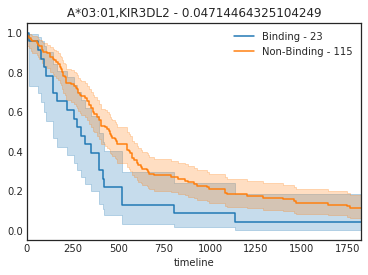

LGG 5.199824606124778
6


<Figure size 432x288 with 0 Axes>

In [59]:
predicted_total = 6
total = 0
for tissue in df.tissue.unique():
    for i, binding_pair in enumerate(binding_pairs_A):
        
        t = df.tissue == tissue
        df_t = df[t]

        T = df_t.days
        C = df_t.observed_event
        
        hla_allele = binding_pair[0]
        kir_gene = binding_pair[1]
        hla = (df_t.A1_ == hla_allele) | (df_t.A2_ == hla_allele)
        kir = (df_t[kir_gene] > 0)

        if sum(C[hla&kir]) > 10 and sum(C[~(hla&kir)]) > 10:
            results = logrank_test(T[hla&kir], T[~(hla&kir)], C[hla&kir], C[~(hla&kir)], alpha=.99 )
            print tissue, results.p_value * predicted_total
            total += 1
            if results.p_value * predicted_total < 0.05:
                print len(df_t[hla&kir]), len(df_t[~(hla&kir)])
                print i, tissue, hla_allele, kir_gene, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[hla&kir], event_observed=C[hla&kir], label="Binding - {0}".format(sum(C[hla&kir])))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~(hla&kir)], event_observed=C[~(hla&kir)], label="Non-Binding - {0}".format(sum(C[~(hla&kir)])))
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.title('{0},{1} - {2}'.format(hla_allele, kir_gene, str(results.p_value * predicted_total)))
                plt.xlim(0, 1825)
                #plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.{0}.{1}_{2}.pdf'.format(tissue, hla_allele, kir_gene))
                plt.show()
                plt.clf()
print total

In [43]:
# follow-up
df_t = df[df.tissue == 'HNSC']
hla_allele = 'A*03:01'
kir_gene = 'KIR3DL2'
hla = (df_t.A1_ == hla_allele) | (df_t.A2_ == hla_allele)
kir = (df_t[kir_gene] > 0)

In [45]:
binding = list(df_t[hla&kir].index)
non_binding = list(df_t[~(hla&kir)].index)

In [46]:
hnsc_clinical[hnsc_clinical.barcode.isin(binding)].viral_status.value_counts()

Negative    12
Positive     4
Name: viral_status, dtype: int64

In [47]:
hnsc_clinical[hnsc_clinical.barcode.isin(non_binding)].viral_status.value_counts()

Negative    49
Positive    22
Name: viral_status, dtype: int64

In [52]:
predicted_total = 1
total = 0
for tissue in df.tissue.unique():
    for i, binding_pair in enumerate(binding_pairs_B):
        hla_allele = binding_pair[0]
        kir_gene = binding_pair[1]
        hla = (df.B1_ == hla_allele) | (df.B2_ == hla_allele)
        kir = (df[kir_gene] > 0)
        
        t = df.tissue == tissue
        df_t = df[t]
        #a = df_t[activating_combo]

        T = df_t.days
        C = df_t.observed_event

        if sum(C[hla&kir]) > 10 and sum(C[~(hla&kir)]) > 10:
            print tissue
            total += 1
            results = logrank_test(T[hla&kir], T[~(hla&kir)], C[hla&kir], C[~(hla&kir)], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print sum(C[hla&kir]), sum(C[~(hla&kir)])
                print i, tissue, hla_allele, kir_gene, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[hla&kir], event_observed=C[hla&kir], label="Binding")
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~(hla&kir)], event_observed=C[~(hla&kir)], label="Non-Binding")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.title('KIR3DL1,Bw4 - {0}'.format(str(results.p_value * predicted_total)))
                plt.xlim(0, 1825)
                plt.show()
                plt.clf()
print total

HNSC
LGG
2


GBM
GBM
GBM
OV
OV
OV
LUAD
12 69
0 C*04:01 ['KIR2DL1', 'KIR2DL2', 'KIR2DL3'] LUAD 0.008587172472617774 0.008587172472617774


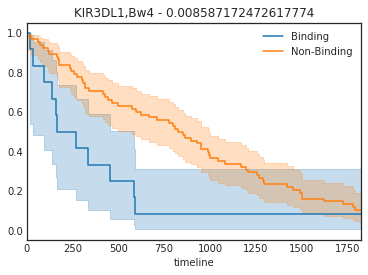

LUAD
HNSC
HNSC
HNSC
HNSC
LGG
LGG
14


<Figure size 432x288 with 0 Axes>

In [60]:
predicted_total = 1
total = 0
for tissue in df.tissue.unique():
    for i, binding_pair in enumerate(binding_pairs_C):
        
        t = df.tissue == tissue
        df_t = df[t]

        T = df_t.days
        C = df_t.observed_event
        
        hla_allele = binding_pair[0]
        kir_gene = binding_pair[1]
        hla = (df_t.C1_ == hla_allele) | (df_t.C2_ == hla_allele)
        greater_than_value = 1
        try:
            kir = (df[kir_gene[0]] + df[kir_gene[1]] > greater_than_value) | (df[kir_gene[2]] > greater_than_value) | (df[kir_gene[3]] > greater_than_value) | (df[kir_gene[4]] > greater_than_value)
        except:
            try:
                kir = (df[kir_gene[0]] > greater_than_value) | (df[kir_gene[1]] > greater_than_value) | (df[kir_gene[2]] > greater_than_value) | (df[kir_gene[3]] > greater_than_value) 
            except:
                try:
                    kir = (df[kir_gene[0]] > greater_than_value) | (df[kir_gene[1]] > greater_than_value) | (df[kir_gene[2]] > greater_than_value) 
                except:
                    try:
                        kir = (df[kir_gene[0]] > greater_than_value) | (df[kir_gene[1]] > greater_than_value)
                    except:
                        kir = (df[kir_gene[0]] > greater_than_value)
                    
        
        if sum(C[hla&kir]) > 11 and sum(C[~(hla&kir)]) > 11:
            print tissue
            total += 1
            results = logrank_test(T[hla&kir], T[~(hla&kir)], C[hla&kir], C[~(hla&kir)], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print sum(C[hla&kir]), sum(C[~(hla&kir)])
                print i, hla_allele, kir_gene, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[hla&kir], event_observed=C[hla&kir], label="Binding")
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~(hla&kir)], event_observed=C[~(hla&kir)], label="Non-Binding")
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.xlim(0, 1825)
                plt.title('KIR3DL1,Bw4 - {0}'.format(str(results.p_value * predicted_total)))
                plt.show()
                plt.clf()
print total

In [55]:
# can we look at the sum instead of the individual? they should all be inhibitory???
predicted_total = 1
total = 0
for tissue in df.tissue.unique():
    for i, binding_pair in enumerate(binding_pairs_C):
        
        t = df.tissue == tissue
        df_t = df[t]

        T = df_t.days
        C = df_t.observed_event
        
        hla_allele = binding_pair[0]
        kir_gene = binding_pair[1]
        hla = (df_t.C1_ == hla_allele) | (df_t.C2_ == hla_allele)
        greater_than_value = 1

        try:
            kir = (df[kir_gene[0]] + df[kir_gene[1]] + df[kir_gene[2]] > 3) 
        except:
            try:
                kir = (df[kir_gene[0]] + df[kir_gene[1]] > 2)
            except:
                 kir = (df[kir_gene[0]] > 1)

        if sum(C[hla&kir]) > 11 and sum(C[~(hla&kir)]) > 11:
            print tissue
            total += 1
            results = logrank_test(T[hla&kir], T[~(hla&kir)], C[hla&kir], C[~(hla&kir)], alpha=.99 )
            if results.p_value * predicted_total < 0.05:
                print sum(C[hla&kir]), sum(C[~(hla&kir)])
                print i, hla_allele, kir_gene, tissue, results.p_value, results.p_value * predicted_total
                ax = plt.subplot(111)
                kmf.fit(T[hla&kir], event_observed=C[hla&kir], label="Binding - {0}".format(sum(C[hla&kir])))
                kmf.plot(ax=ax, ci_force_lines=False)
                kmf.fit(T[~(hla&kir)], event_observed=C[~(hla&kir)], label="Non-Binding - {0}".format(sum(C[~(hla&kir)])))
                kmf.plot(ax=ax, ci_force_lines=False)
                plt.title('{0},{1} - {2}'.format(hla_allele, kir_gene, str(results.p_value * predicted_total)))
                plt.xlim(0, 1825)
                plt.savefig('/cellar/users/ramarty/Data/kir/figures/survival.{0}.{1}_{2}.pdf'.format(tissue, hla_allele, kir_gene[0]))
                
                plt.show()
                plt.clf()
print total

GBM
OV
HNSC
3


In [58]:
df_t = df[df.tissue == 'HNSC']
hla_allele = 'C*04:01'
kir = (df['KIR2DL1'] + df['KIR2DL2'] + df['KIR2DL3'] > 3) 
hla = (df_t.C1_ == hla_allele) | (df_t.C2_ == hla_allele)

In [59]:
binding = list(df_t[hla&kir].Tumor_Sample_Barcode)
non_binding = list(df_t[~(hla&kir)].Tumor_Sample_Barcode)

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


AttributeError: 'DataFrame' object has no attribute 'Tumor_Sample_Barcode'

In [ ]:
hnsc_clinical[hnsc_clinical.barcode.isin(binding)].viral_status.value_counts()

In [ ]:
hnsc_clinical[hnsc_clinical.barcode.isin(non_binding)].viral_status.value_counts()

Activating and inhibitory

GBM 27 27
0.2333916059291759
OV 23 26
0.009868288856019211
23 26
13 C*18:02 OV 0.009868288856019211 0.009868288856019211


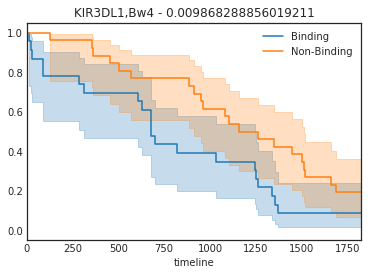

LUAD 22 25
0.9937668401160206
HNSC 43 37
0.7453465791787699
4


<Figure size 432x288 with 0 Axes>

In [57]:
predicted_total = 1
total = 0
for tissue in df.tissue.unique():

    t = df.tissue == tissue
    df_t = df[t]

    T = df_t.days
    C = df_t.observed_event
    
    low_activating = (df_t.activating < 5)
    high_activating = (df_t.activating > 6)

    if sum(C[low_activating]) > 20 and sum(C[high_activating]) > 20:
        print tissue, sum(C[low_activating]), sum(C[high_activating])
        total += 1
        results = logrank_test(T[low_activating], T[high_activating], C[low_activating], C[high_activating], alpha=.99)
        print results.p_value
        if results.p_value * predicted_total < 0.05:
            print sum(C[low_activating]), sum(C[high_activating])
            print i, hla_allele, tissue, results.p_value, results.p_value * predicted_total
            ax = plt.subplot(111)
            kmf.fit(T[low_activating], event_observed=C[low_activating], label="Binding")
            kmf.plot(ax=ax, ci_force_lines=False)
            kmf.fit(T[high_activating], event_observed=C[high_activating], label="Non-Binding")
            kmf.plot(ax=ax, ci_force_lines=False)
            plt.title('KIR3DL1,Bw4 - {0}'.format(str(results.p_value * predicted_total)))
            plt.xlim(0, 1825)
            plt.show()
            plt.clf()
print total

In [60]:
df.inhibitory.describe()

count    3501.000000
mean       11.924307
std         1.430379
min         6.000000
25%        11.000000
50%        12.000000
75%        12.000000
max        20.000000
Name: inhibitory, dtype: float64

In [58]:
predicted_total = 1
total = 0
for tissue in df.tissue.unique():

    t = df.tissue == tissue
    df_t = df[t]

    T = df_t.days
    C = df_t.observed_event
    
    low_activating = (df_t.inhibitory <= 11)
    high_activating = (df_t.inhibitory >= 12)

    if sum(C[low_activating]) > 5 and sum(C[high_activating]) > 5:
        print tissue, sum(C[low_activating]), sum(C[high_activating])
        total += 1
        results = logrank_test(T[low_activating], T[high_activating], C[low_activating], C[high_activating], alpha=.99)
        print results.p_value
        if results.p_value * predicted_total < 0.05:
            print sum(C[low_activating]), sum(C[high_activating])
            print i, hla_allele, tissue, results.p_value, results.p_value * predicted_total
            ax = plt.subplot(111)
            kmf.fit(T[low_activating], event_observed=C[low_activating], label="Binding")
            kmf.plot(ax=ax, ci_force_lines=False)
            kmf.fit(T[high_activating], event_observed=C[high_activating], label="Non-Binding")
            kmf.plot(ax=ax, ci_force_lines=False)
            plt.title('KIR3DL1,Bw4 - {0}'.format(str(results.p_value * predicted_total)))
            plt.xlim(0, 1825)
            plt.show()
            plt.clf()
print total

GBM 26 64
0.10525043342327911
OV 13 63
0.9240271723193527
LUAD 23 58
0.8776662105486885
LUSC 11 25
0.3462019047117919
PAAD 14 14
0.528451277171625
KIRC 10 19
0.581579205240436
HNSC 29 109
0.12311399696425407
BLCA 8 26
0.35983188945078415
LGG 24 61
0.11104544678572838
UCS 12 16
0.7963490002466653
10


Combine all inhibitory and activating instead of testing them individually